In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [25]:
train_dir = "drive/MyDrive/Colab Notebooks/Colab Notebooks/nn_datasets/train/"
val_dir = "drive/MyDrive/Colab Notebooks/Colab Notebooks/nn_datasets/val/"
test_dir = "drive/MyDrive/Colab Notebooks/Colab Notebooks/nn_datasets/test/"

image_size = (720, 960)
batch_size = 2

datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'input',
    color_mode = 'rgb',
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'input',
    color_mode = 'rgb',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'input',
    color_mode = 'rgb',
    shuffle = False
)

Found 480 images belonging to 1 classes.
Found 59 images belonging to 1 classes.
Found 67 images belonging to 1 classes.


In [4]:
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, num_examples=2):
        super().__init__()
        self.validation_generator = validation_generator
        self.num_examples = num_examples

    def on_epoch_end(self, epoch, logs=None):
        x_val, _ = next(self.validation_generator)

        predictions = self.model.predict(x_val, verbose=0)

        for i in range(self.num_examples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(x_val[i])
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(x_val[i])
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i])
            plt.title("Reconstructed Image")
            plt.axis('off')

            plt.show()

In [5]:
class PeriodicCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_freq):
        super().__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))
            print(f"Checkpoint saved at epoch {epoch + 1}")

In [17]:
input_shape = (image_size[0], image_size[1], 3)
input_img = layers.Input(shape=input_shape)

x = layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D((2, 2), padding = 'same')(x)
x = layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D((2, 2), padding = 'same')(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D((2, 2), padding = 'same')(x)
x = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)

x = layers.UpSampling2D((2, 2))(encoded)
x = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x)
decoded = layers.Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(x)

# autoencoder = models.Model(input_img, decoded)
autoencoder = load_model('drive/MyDrive/Colab Notebooks/Colab Notebooks/checkpoints2/autoencoder_epoch_09.h5')
autoencoder.compile(optimizer = 'AdamW', loss = 'mean_squared_error')
checkpoint_callback = PeriodicCheckpoint(
    filepath='drive/MyDrive/Colab Notebooks/Colab Notebooks/checkpoints2/autoencoder_epoch_{epoch:02d}.h5',
    save_freq=1
)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 720, 960, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 720, 960, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 360, 480, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 360, 480, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 180, 240, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 180, 240, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 120, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 90, 120, 64)         │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 90, 120, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 180, 240, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 180, 240, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 360, 480, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 360, 480, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 720, 960, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 720, 960, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 720, 960, 3)         │           6,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,975,971 (7.54 MB)

 Trainable params: 1,975,971 (7.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
prediction_callback = PredictionCallback(test_generator, num_examples=2)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0034

Checkpoint saved at epoch 1


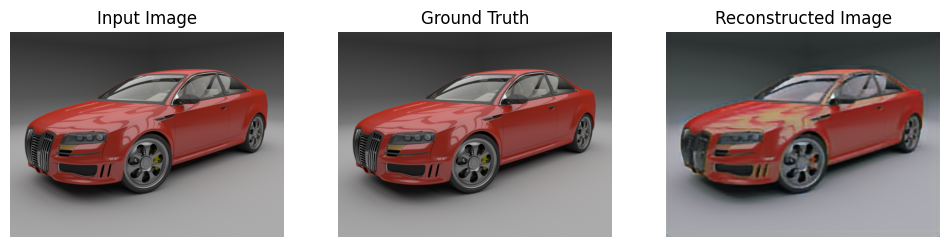

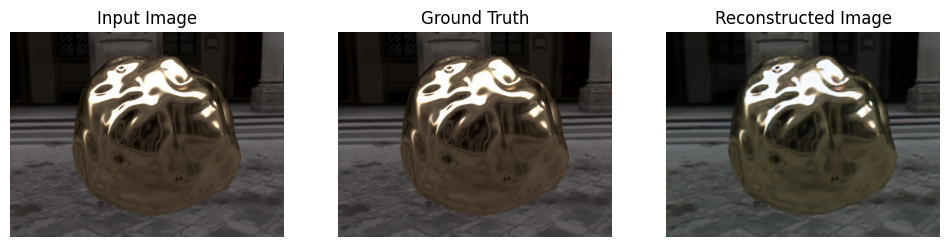

240/240 ━━━━━━━━━━━━━━━━━━━━ 703s 3s/step - loss: 0.0034 - val_loss: 0.0026
Epoch 2/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0037

Checkpoint saved at epoch 2


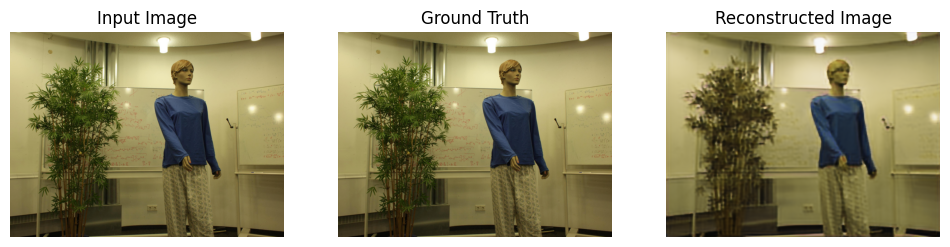

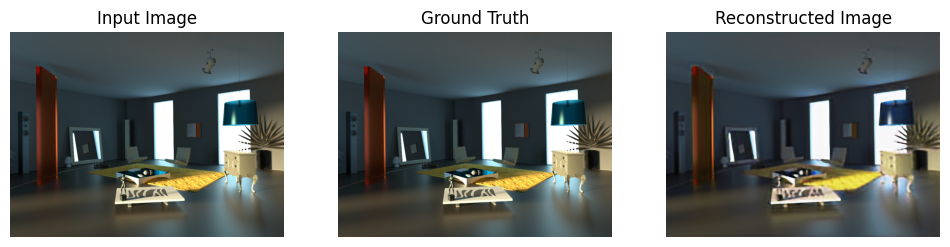

240/240 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 0.0037 - val_loss: 0.0021
Epoch 3/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0025

Checkpoint saved at epoch 3


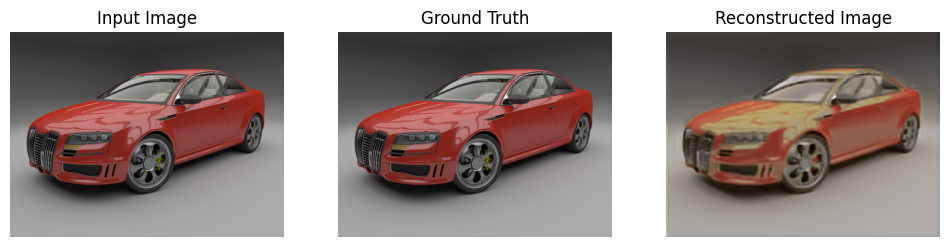

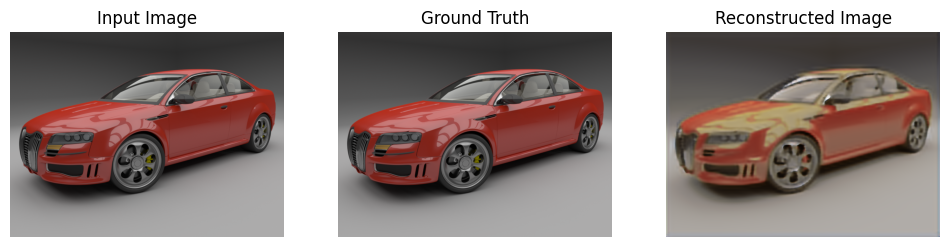

240/240 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - loss: 0.0025 - val_loss: 0.0058
Epoch 4/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0108

Checkpoint saved at epoch 4


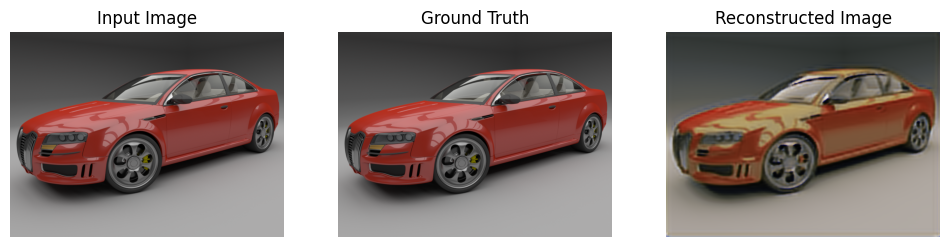

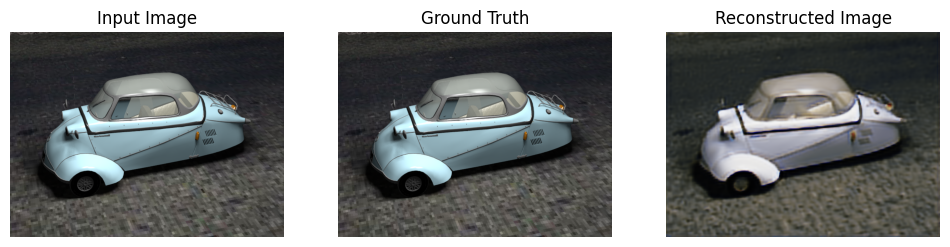

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0108 - val_loss: 0.0035
Epoch 5/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0039

Checkpoint saved at epoch 5


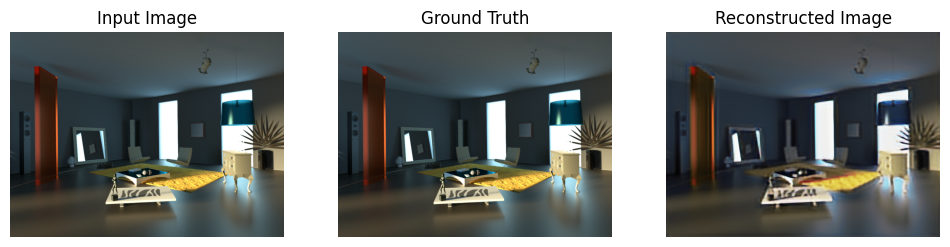

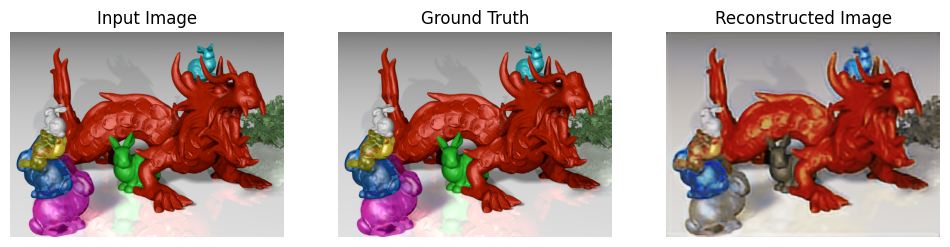

240/240 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - loss: 0.0039 - val_loss: 0.0026
Epoch 6/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0025

Checkpoint saved at epoch 6


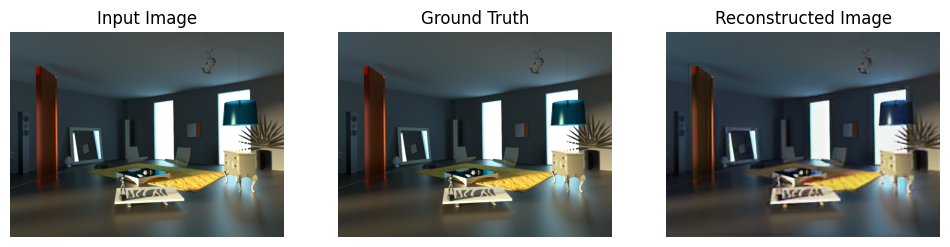

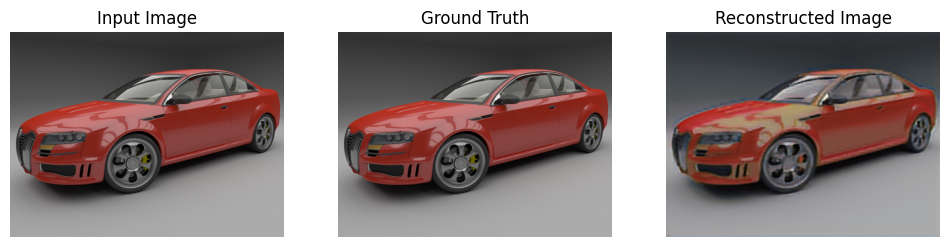

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0023

Checkpoint saved at epoch 7


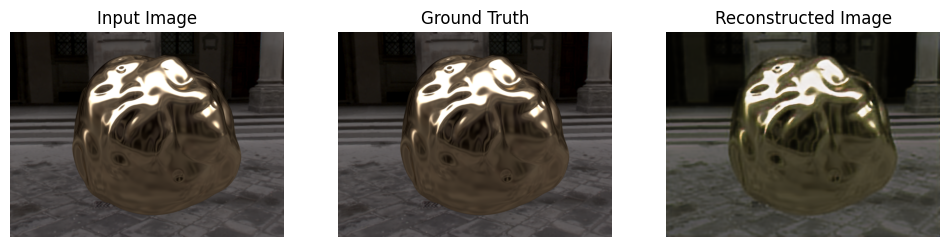

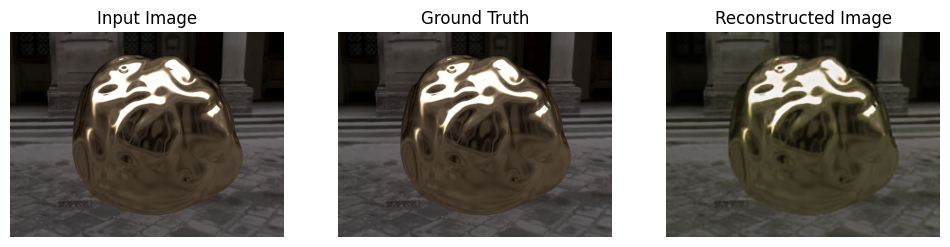

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0024

Checkpoint saved at epoch 8


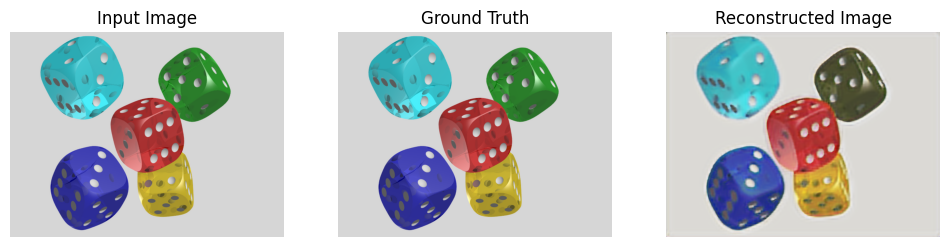

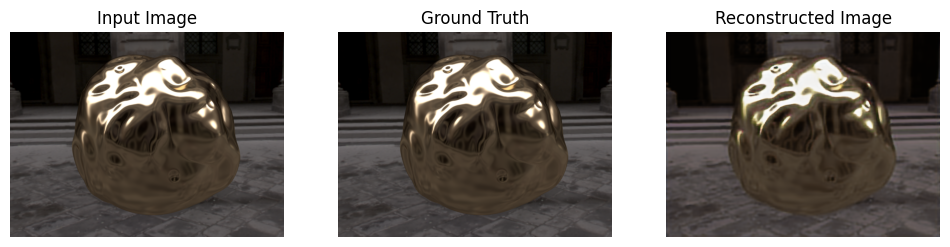

240/240 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0020

Checkpoint saved at epoch 9


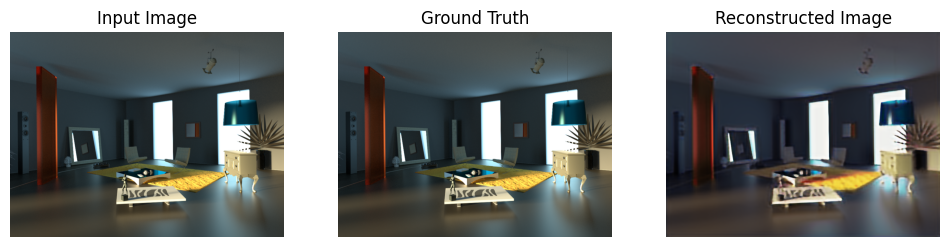

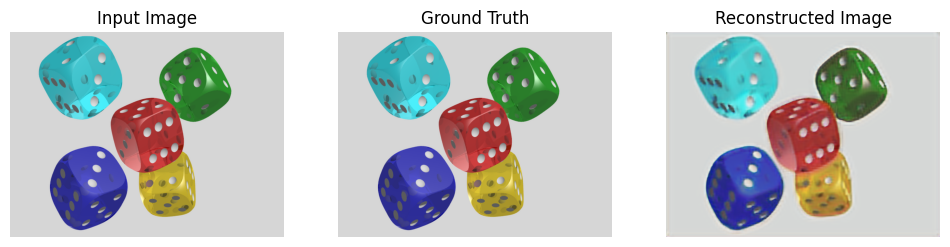

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0019

Checkpoint saved at epoch 10


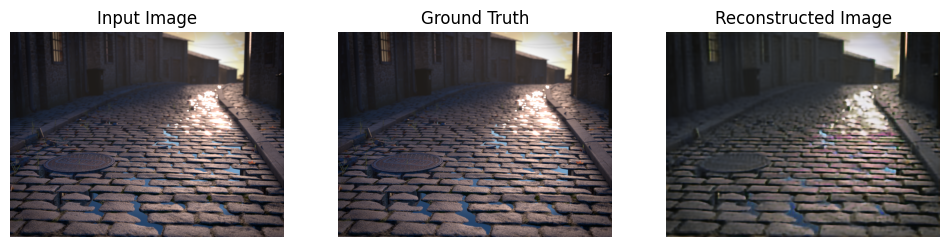

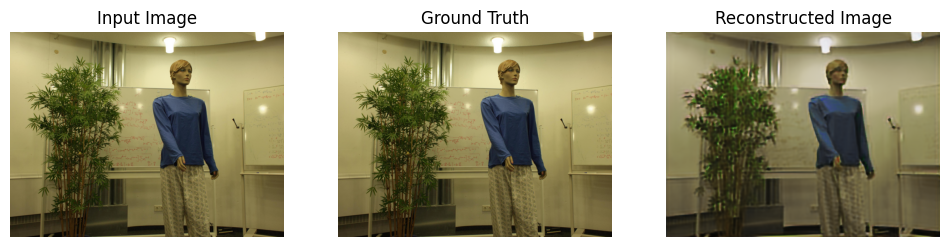

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0019 - val_loss: 0.0041
Epoch 11/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0067

Checkpoint saved at epoch 11


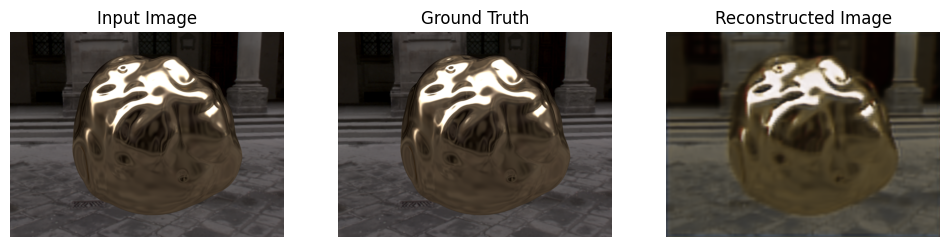

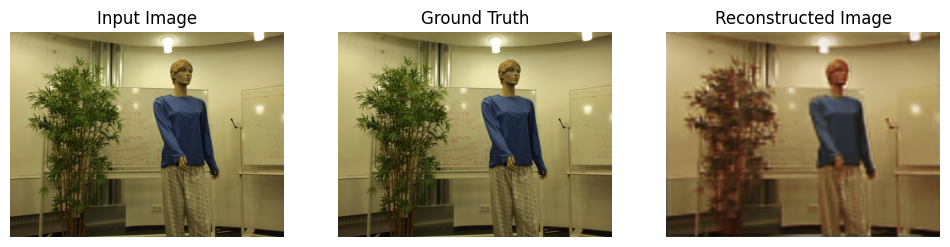

240/240 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - loss: 0.0067 - val_loss: 0.0085
Epoch 12/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0050

Checkpoint saved at epoch 12


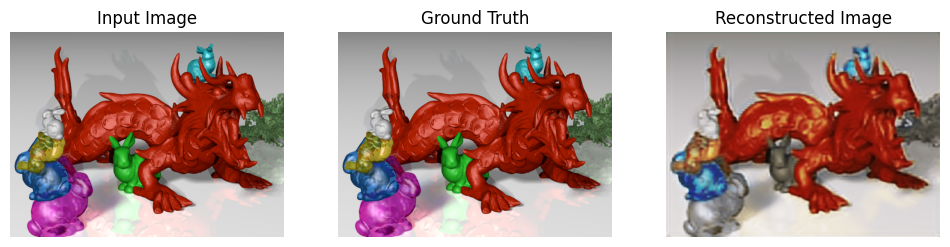

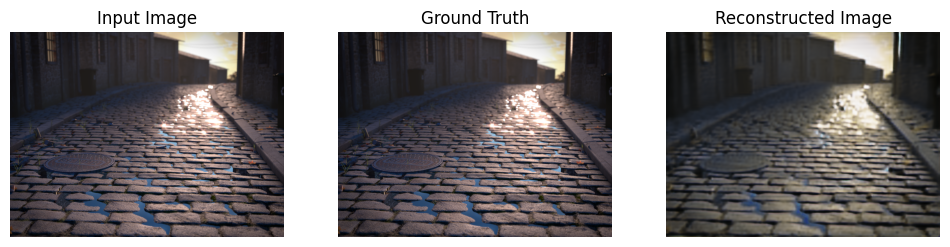

240/240 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - loss: 0.0050 - val_loss: 0.0030
Epoch 13/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0061

Checkpoint saved at epoch 13


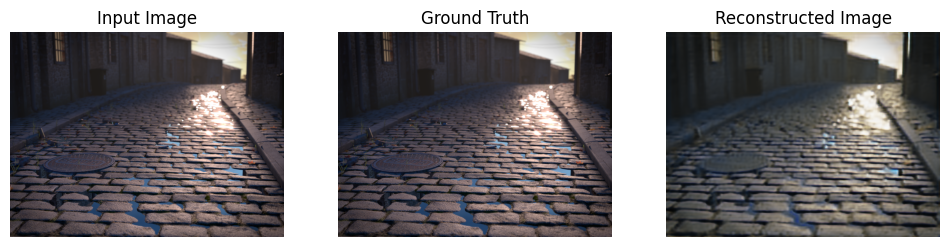

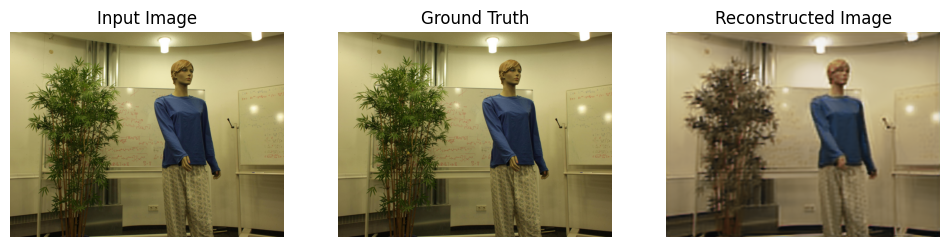

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0061 - val_loss: 0.0033
Epoch 14/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0034

Checkpoint saved at epoch 14


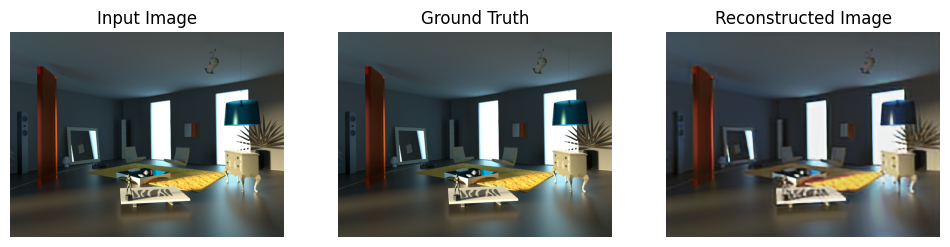

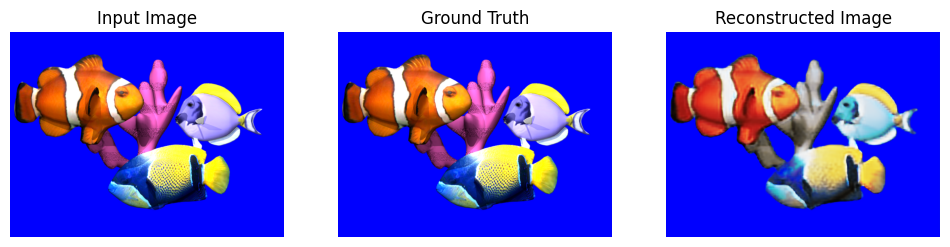

240/240 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - loss: 0.0034 - val_loss: 0.0028
Epoch 15/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0031

Checkpoint saved at epoch 15


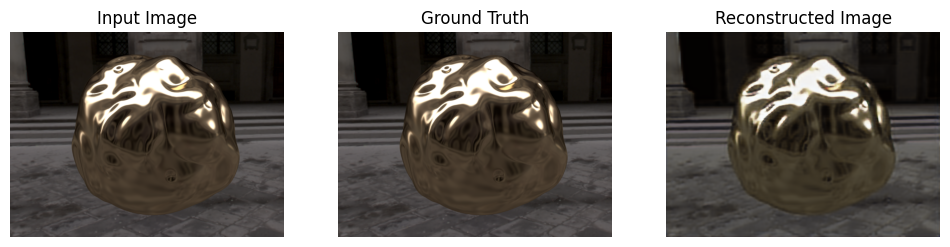

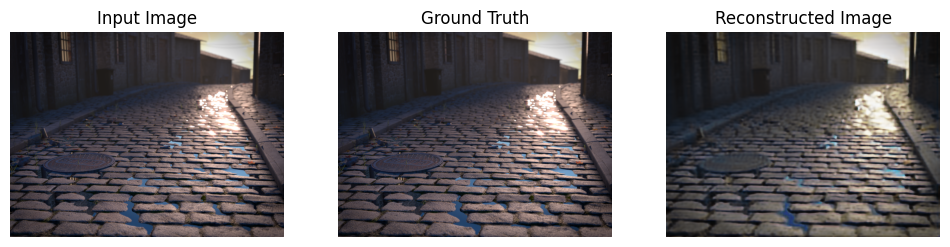

240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 0.0031 - val_loss: 0.0026


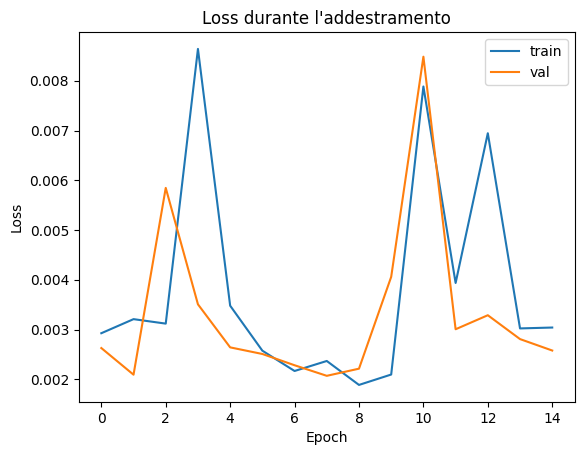

In [ ]:
history = autoencoder.fit(
    train_generator,
    epochs = 15,
    callbacks = [checkpoint_callback, prediction_callback],
    validation_data = validation_generator,
    verbose = 1,
)

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('Loss durante l\'addestramento')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [26]:
c = 0
while c < 67:
    batch = next(test_generator)
    decoded_images = autoencoder.predict(batch[0])
    n = len(decoded_images)
    for i in range(n):
        plt.imshow(decoded_images[i])
        plt.axis("off")
        plt.savefig(f'drive/MyDrive/Colab Notebooks/Colab Notebooks/decoded/decoded_{c}.png', transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close()
        c += 1
        print(f"Img numero: {c}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Img numero: 1
Img numero: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Img numero: 3
Img numero: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Img numero: 5
Img numero: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 7
Img numero: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 9
Img numero: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 11
Img numero: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 13
Img numero: 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Img numero: 15
Img numero: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 17
Img numero: 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Img numero: 19
Img numero: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Img numero: 21
Img numero: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Img numero: 23
Img numero: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Img numero: 25
Img numero: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Img numero: 27
Img numero: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Img numero: 29
Img 